In [ ]:
# Google Drive マウント
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/My Drive/卒業研究/DeadReckoning_ExperimentalData/ML'
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/卒業研究/DeadReckoning_ExperimentalData/ML
data/                ML_angle.ipynb      __pycache__/
DeadReckoning.ipynb  ML.ipynb            result_ML_MultiData.csv
graph/               ML_MultiData.ipynb  result_ML_MultiData.gsheet
loaddata.ipynb       model/              scripts/
logs/                optuna.ipynb        Untitled0.ipynb
makedata.ipynb       others/


In [ ]:
# !pip install --upgrade tensorflow
!pip install optuna

In [ ]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import mean_absolute_error

plt.style.use('ggplot')

In [ ]:
import optuna

In [ ]:
def load_data(filename):
    data = np.loadtxt(filename, delimiter=',', skiprows=1,
                      unpack=False, dtype=str)
    speed = []
    xyzwave = []
    for row in data:
        speed.append(row[1].astype('f8'))
        xyzwave.append(row[2: 2 + 3*50].astype('f8'))
    speed = np.array(speed)
    x = np.array(xyzwave)
    t = speed[:, np.newaxis]
    return x, t

In [ ]:
# データの読み込み
# x1, t1 = load_data('data/191106_1152/ML.csv')
# x2, t2 = load_data('data/191121_1625/ML.csv')
# x3, t3 = load_data('data/191204_1956/ML.csv')
# x = np.concatenate([x1, x2, x3], axis=0)
# t = np.concatenate([t1, t2, t3], axis=0)

x, t = load_data('data/191121_1625/ML.csv')
# x, t = load_data('data/191106_1152/ML.csv')
# x, t = load_data('data/191204_1956/ML.csv')
# x, t = load_data('data/191204_2012/ML.csv')
# x, t = load_data('data/191211_1649/ML.csv')

# SPEED_MAX = 2.5
# t /= SPEED_MAX 

# 学習データとテストデータに分割
from sklearn.model_selection import train_test_split
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.1)

In [ ]:
# ハイパーパラメータ
activation = 'tanh'
activation_output = 'sigmoid'
learning_rate = 0.001
batch_size = 32
optimizer = 'adam'
loss = 'mse'

In [ ]:
import keras.backend as K
from tensorflow.keras.layers import * 
from tensorflow.keras.models import Model

# モデル生成
def vector_model(num_layer, num_units, activation):
    K.clear_session()
    inputs = Input((150,))
    x = Dense(num_units[0], activation=activation)(inputs)
    # x = Dropout(num_dropout)(x)
    for i in range(1, num_layer):
        # x = Dropout(num_dropouts[i])(x)
        x = Dense(num_units[i], activation=activation)(x)
    x = Dense(1, activation='linear')(x)
    return Model(inputs=inputs, outputs=x)

In [ ]:
def objective(trial):
    #セッションのクリア
    K.clear_session()

    #最適化するパラメータの設定
    #中間層の数
    num_layer = trial.suggest_int('num_layer', 3, 7)

    #各層のユニット数
    num_units = [int(trial.suggest_discrete_uniform('num_unit_'+str(i), 16, 128, 16)) for i in range(num_layer)]

    #各層のドロップアウト確率
    # num_dropout = [trial.suggest_discrete_uniform('num_dropout_'+str(i), 0, 0.5, 0.1) for i in range(num_layer)]
    # num_dropout = trial.suggest_discrete_uniform('num_dropout', 0, 0.5, 0.1)

    #活性化関数
    activation = trial.suggest_categorical('activation', ['relu', 'sigmoid', 'tanh'])

    #optimizer
    optimizer = trial.suggest_categorical('optimizer', ['sgd', 'adam', 'rmsprop'])

    model = vector_model(num_layer, num_units, activation)
    model.compile(optimizer=optimizer,
                    loss='mse',
                    metrics=['mae'])

    result = model.fit(x_train, t_train, epochs=20,
                    batch_size=batch_size, verbose=0, 
                    # callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_mae', min_delta=0, patience=10),
                    validation_data=(x_test, t_test))
    
    return result.history['val_mae'][-1]

In [ ]:
study = optuna.create_study()
study.optimize(objective, n_trials=50)

[I 2020-08-02 21:40:52,753] Trial 0 finished with value: 0.2545502483844757 and parameters: {'num_layer': 5, 'num_unit_0': 48.0, 'num_unit_1': 80.0, 'num_unit_2': 128.0, 'num_unit_3': 80.0, 'num_unit_4': 80.0, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.2545502483844757.
[I 2020-08-02 21:40:57,264] Trial 1 finished with value: 0.18834088742733002 and parameters: {'num_layer': 6, 'num_unit_0': 96.0, 'num_unit_1': 112.0, 'num_unit_2': 80.0, 'num_unit_3': 128.0, 'num_unit_4': 32.0, 'num_unit_5': 32.0, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 1 with value: 0.18834088742733002.
[I 2020-08-02 21:41:00,281] Trial 2 finished with value: 0.12161462754011154 and parameters: {'num_layer': 6, 'num_unit_0': 80.0, 'num_unit_1': 80.0, 'num_unit_2': 112.0, 'num_unit_3': 16.0, 'num_unit_4': 80.0, 'num_unit_5': 112.0, 'activation': 'relu', 'optimizer': 'sgd'}. Best is trial 2 with value: 0.12161462754011154.
[I 2020-08-02 21:41:03,674] Trial 3 f

In [ ]:
import pprint

pprint.pprint(study.best_params)
print(study.best_value)

{'activation': 'relu',
 'num_layer': 7,
 'num_unit_0': 80.0,
 'num_unit_1': 128.0,
 'num_unit_2': 96.0,
 'num_unit_3': 80.0,
 'num_unit_4': 32.0,
 'num_unit_5': 16.0,
 'num_unit_6': 64.0,
 'optimizer': 'adam'}
0.07778085023164749


In [ ]:
model = vector_model(5, [96, 48, 112, 96, 80], 'relu')
model.compile(optimizer='rmsprop',
                loss='mse',
                metrics=['mae'])

result = model.fit(x_train, t_train, epochs=20,
                batch_size=batch_size, 
                validation_data=(x_test, t_test))

Epoch 1/20
53/53 [==============================] - 0s 6ms/step - loss: 0.1742 - mae: 0.3041 - val_loss: 0.1860 - val_mae: 0.3918
Epoch 2/20
53/53 [==============================] - 0s 4ms/step - loss: 0.0557 - mae: 0.1882 - val_loss: 0.0413 - val_mae: 0.1507
Epoch 3/20
53/53 [==============================] - 0s 4ms/step - loss: 0.0426 - mae: 0.1613 - val_loss: 0.0348 - val_mae: 0.1416
Epoch 4/20
53/53 [==============================] - 0s 4ms/step - loss: 0.0376 - mae: 0.1529 - val_loss: 0.0273 - val_mae: 0.1276
Epoch 5/20
53/53 [==============================] - 0s 4ms/step - loss: 0.0326 - mae: 0.1404 - val_loss: 0.0214 - val_mae: 0.1079
Epoch 6/20
53/53 [==============================] - 0s 4ms/step - loss: 0.0265 - mae: 0.1281 - val_loss: 0.0292 - val_mae: 0.1366
Epoch 7/20
53/53 [==============================] - 0s 4ms/step - loss: 0.0232 - mae: 0.1172 - val_loss: 0.0206 - val_mae: 0.1126
Epoch 8/20
53/53 [==============================] - 0s 4ms/step - loss: 0.0219 - mae: 0.11

In [ ]:
y_train = model.predict(x_train)
# t_train *= SPEED_MAX
# y_train *= SPEED_MAX

y_test = model.predict(x_test)
# t_test *= SPEED_MAX
# y_test *= SPEED_MAX

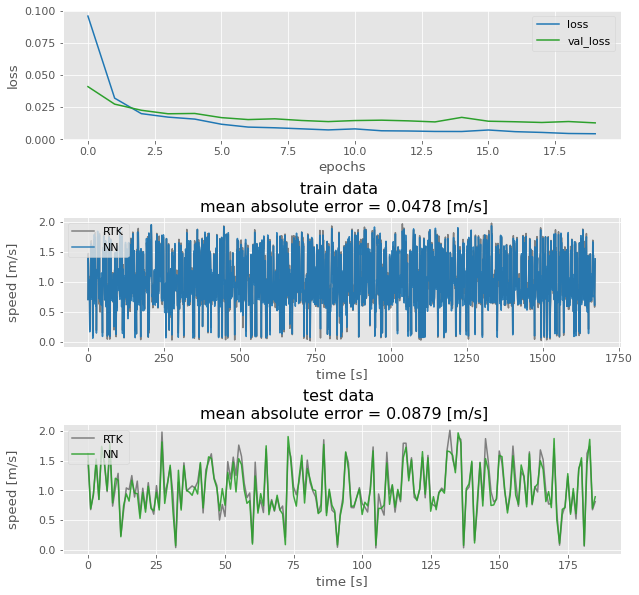

In [ ]:
def plot_result():
    fig = plt.figure(figsize=(10, 10))

    ax1 = fig.add_subplot(311)
    # ax1.set_title('activation={}, '.format(activation) + 
    #                 'activation_output={}, \n'.format(activation_output) + 
    #                 'learning_rate={}, '.format(learning_rate) +
    #                 'optimizer={}, '.format(optimizer) + 
    #                 'loss={}'.format(loss))
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('loss')
    ax1.plot(result.history['loss'], color='tab:blue', label='loss')
    ax1.plot(result.history['val_loss'], color='tab:green', label='val_loss')
    ax1.legend(loc='upper right')

    ax2 = fig.add_subplot(312)
    mae_train = mean_absolute_error(t_train, y_train)
    ax2.set_title('train data \n mean absolute error = {0:.3} [m/s]' \
                  .format(mae_train))
    ax2.set_xlabel('time [s]')
    ax2.set_ylabel('speed [m/s]')
    ax2.plot(t_train, color='tab:gray', label='RTK')
    ax2.plot(y_train, color='tab:blue', label='NN', alpha=0.9)
    ax2.legend(loc='upper left')

    ax3 = fig.add_subplot(313)
    mae_test = mean_absolute_error(t_test, y_test)
    ax3.set_title('test data \n mean absolute error = {0:.3} [m/s]' \
                  .format(mae_test))
    ax3.set_xlabel('time [s]')
    ax3.set_ylabel('speed [m/s]')
    ax3.plot(t_test, color='tab:gray', label='RTK')
    ax3.plot(y_test, color='tab:green', label='NN', alpha=0.9)
    ax3.legend(loc='upper left')

    fig.align_labels()
    fig.subplots_adjust(hspace=0.6)
    # fig.savefig('graph/graph.png')

# 学習結果
plt.rcParams['font.size'] = 11
plot_result()

In [ ]:
def test(filename: str):
    x, t = load_data(filename)
    y = model.predict(x) * SPEED_MAX
    return t, y

def plot_test(t, y):
    fig = plt.figure(figsize=(7.5, 5))
    ax = fig.add_subplot(111)
    mae = mean_absolute_error(t, y)
    # ax.set_title('mean absolute error = {:.3} [m/s]'.format(mae))
    ax.set_xlabel('time [s]')
    ax.set_ylabel('speed [m/s]')
    ax.plot(t, color='gray', label='RTK')
    ax.plot(y, color='tab:blue', label='NN', alpha=0.7)
    ax.legend(loc='upper left')
    print(len(t))

1860
671
715
554
663


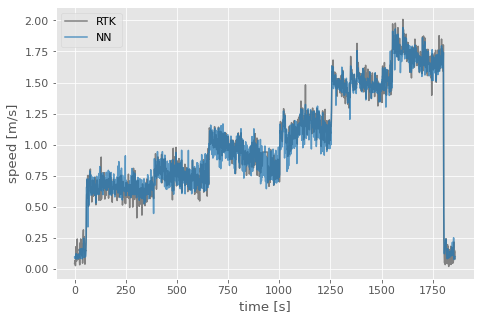

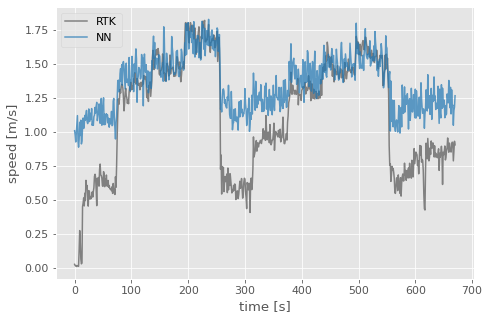

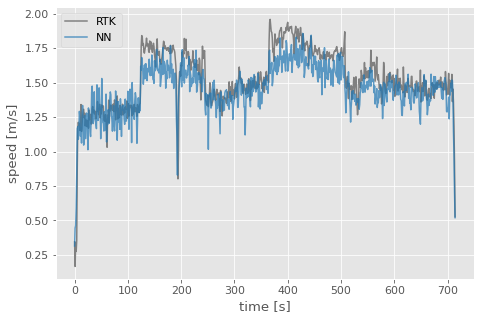

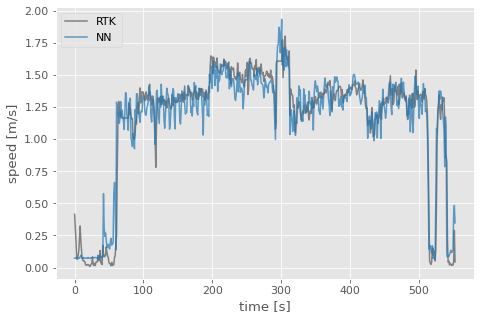

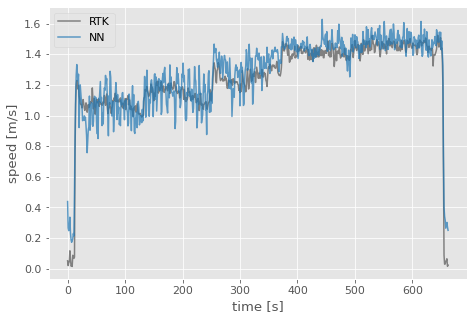

In [ ]:
t, y = test('data/191121_1625/ML.csv')
plot_test(t, y)

t, y = test('data/191106_1152/ML.csv')
plot_test(t[10:-5], y[10:-5])

t, y = test('data/191204_1956/ML.csv')
plot_test(t, y)

t, y = test('data/191204_2012/ML.csv')
plot_test(t, y)

t, y = test('data/191211_1649/ML.csv')
plot_test(t[15:-5], y[15:-5])